In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle as pkl
import sys
import seaborn as sns

from fastFM import als
from scipy.sparse import csc_matrix, hstack, vstack
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK
from collections import OrderedDict
from sklearn.linear_model import ElasticNet

% matplotlib inline
sns.set_style('whitegrid')

### Import data

In [3]:
# import full data
data_path = os.path.join('..','..', 'data-2')
splits_path = os.path.join(data_path,'splits')
sparse_path = os.path.join(data_path, 'sparse')
columns = ['user','item','rating']

with open(os.path.join(splits_path, 'train.df'), 'rb') as file_in:
    train_df = pkl.load(file_in)
    
with open(os.path.join(splits_path, 'dev.df'), 'rb') as file_in:
    cv_df = pkl.load(file_in)
    
with open(os.path.join(splits_path, 'test.df'), 'rb') as file_in:
    test_df = pkl.load(file_in)
        
# import results from LSH, Baseline, FM with ratings only, and FM with LSH and Baseline results as features
results_lsh_train = pd.read_csv(os.path.join(data_path, 'results_lsh_train.csv'))
results_lsh_cv = pd.read_csv(os.path.join(data_path, 'results_lsh_cv.csv'))
results_lsh_test = pd.read_csv(os.path.join(data_path, 'results_lsh_test.csv'))

results_baseline_train = pd.read_csv(os.path.join(data_path, 'results_baseline_train.csv'))
results_baseline_cv = pd.read_csv(os.path.join(data_path, 'results_baseline_cv.csv'))
results_baseline_test = pd.read_csv(os.path.join(data_path, 'results_baseline_test.csv'))

results_fm_ratings_train = pd.read_csv(os.path.join(data_path, 'results_fm_ratings_train.csv'))
results_fm_ratings_cv = pd.read_csv(os.path.join(data_path, 'results_fm_ratings_cv.csv'))
results_fm_ratings_test = pd.read_csv(os.path.join(data_path, 'results_fm_ratings_test.csv'))

results_fm_lsh_train = pd.read_csv(os.path.join(data_path, 'results_fm_lsh_train.csv'))
results_fm_lsh_cv = pd.read_csv(os.path.join(data_path, 'results_fm_lsh_cv.csv'))
results_fm_lsh_test = pd.read_csv(os.path.join(data_path, 'results_fm_lsh_test.csv'))

train_df['pred_lsh'] = results_lsh_train['prediction'].values
train_df['pred_baseline'] = results_baseline_train['pred'].values
train_df['pred_fm_ratings'] = np.clip(results_fm_ratings_train['prediction'].values, a_min=1, a_max=5)
train_df['pred_fm_lsh'] = np.clip(results_fm_lsh_train['prediction'].values, a_min=1, a_max=5)

cv_df['pred_lsh'] = results_lsh_cv['prediction'].values
cv_df['pred_baseline'] = results_baseline_cv['pred'].values
cv_df['pred_fm_ratings'] = np.clip(results_fm_ratings_cv['prediction'].values,  a_min=1, a_max=5)
cv_df['pred_fm_lsh'] = np.clip(results_fm_lsh_cv['prediction'].values, a_min=1, a_max=5)

test_df['pred_lsh'] = results_lsh_test['prediction'].values
test_df['pred_baseline'] = results_baseline_test['pred'].values
test_df['pred_fm_ratings'] = np.clip(results_fm_ratings_test['prediction'].values, a_min=1, a_max=5)
test_df['pred_fm_lsh'] = np.clip(results_fm_lsh_test['prediction'].values, a_min=1, a_max=5)

In [103]:
preds = ['pred_lsh', 'pred_baseline', 'pred_fm_ratings']

X_train = train_df[preds]
X_cv = cv_df[preds]
X_test = test_df[preds]

y_train = train_df['rating']
y_cv = cv_df['rating']
y_test = test_df['rating']

In [104]:
def test_xgb(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    print(params)
    
    xgb = XGBRegressor(**params)
    xgb.fit(X_train, y_train)
    y_train_pred = xgb.predict(X_train)
    y_cv_pred = xgb.predict(X_cv)
    mae = mean_absolute_error(y_cv_pred, y_cv)
    print(mae)
    return mae

In [68]:
XGBRegressor()

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [105]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'trials_ensemble'), 'rb') as file_in:
        trials = pkl.load(file_in)
    with open(os.path.join(data_path, 'best_ensemble.dict'), 'rb') as file_in:
        best = pkl.load(file_in)
else:
    trials = Trials()
    space = {
        'reg_alpha': hp.uniform('reg_alpha', 0, 3),
        'reg_lambda': hp.uniform('reg_lambda', 0, 3),
        'subsample': hp.uniform('subsample', 0, 1),
        'max_depth': hp.uniform('max_depth', 1, 5),
        'n_estimators': hp.uniform('n_estimators', 50, 300),
        'learning_rate': hp.uniform('learning_rate', 0, 0.5)    
    }

    # Choose the Tree-structured Parzen Estimator (TPE) as the algorithm to optimize the objective function
    best = fmin(algo = tpe.suggest,
               fn = test_xgb,
               trials = trials,
               max_evals = 50, # max number of tests
               space = space)
    with open(os.path.join(data_path, 'trials_ensemble'), 'wb') as file_out:
        pkl.dump(trials, file_out)
    with open(os.path.join(data_path, 'best_ensemble.dict'), 'wb') as file_out:
        pkl.dump(best, file_out)

In [110]:
def val_diagnostic(val_name, trials):
    '''generates scatter plot and histogram of each parameter, as well as a plot on loss values (MAE)'''
    
    vals = np.array([trial['misc']['vals'][val_name] for trial in trials.trials])
    
    if val_name in ['max_depth', 'n_estimators']:
        vals = [int(x) for x in vals]
        
    ts = [trial['tid'] for trial in trials.trials]
    results = [trial['result']['loss'] for trial in trials.trials]
    
    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    axes[0].scatter(ts, vals)
    axes[0].set(xlabel='iteration', ylabel=val_name)
    axes[1].hist(np.array(vals).squeeze())
    axes[1].set(xlabel=val_name, ylabel='frequency')
    axes[2].scatter(vals, results)
    axes[2].set(xlabel=val_name, ylabel='loss', ylim = (0.5, 0.8))
    plt.tight_layout()

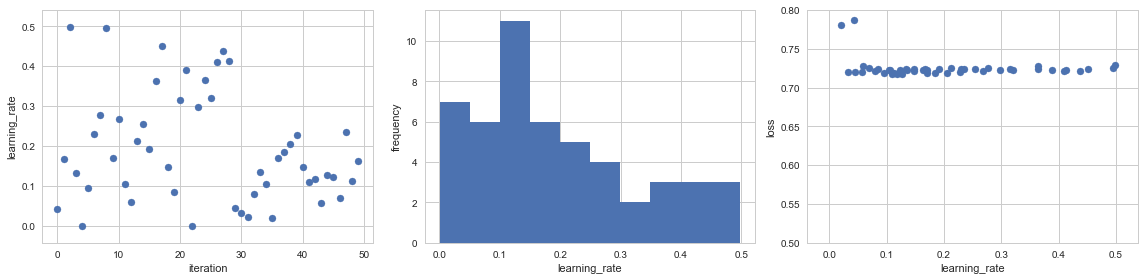

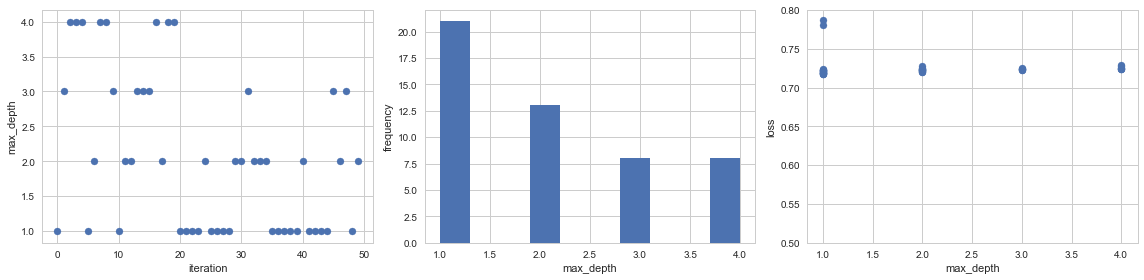

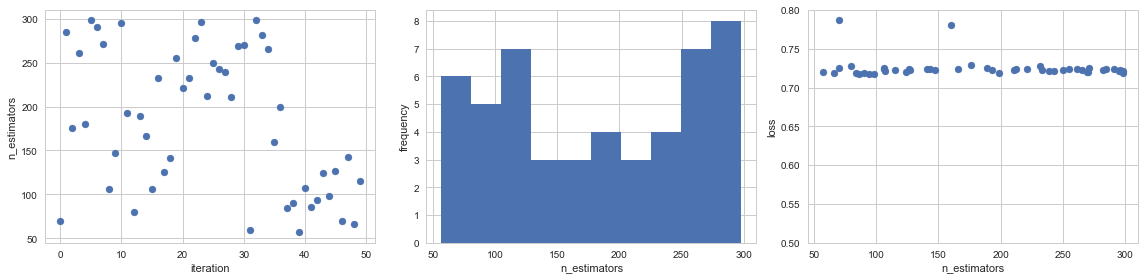

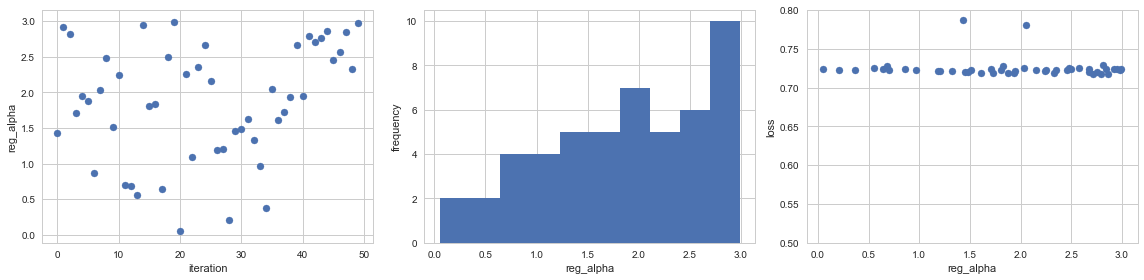

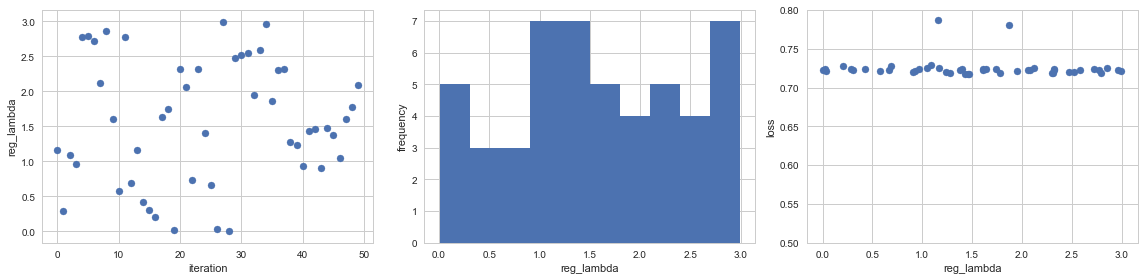

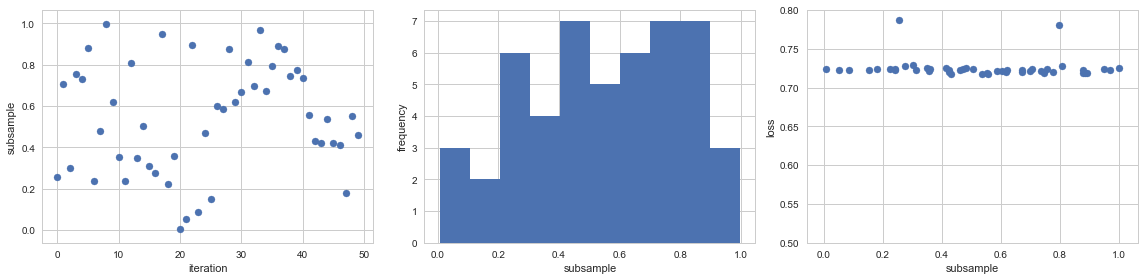

In [111]:
for val in trials.trials[0]['misc']['vals'].keys():
    val_diagnostic(val, trials)

In [108]:
best_opt = best.copy()
for param in ['max_depth', 'n_estimators']:
    best_opt[param] = int(best_opt[param])
best_opt

{'learning_rate': 0.11850195385788272,
 'max_depth': 1,
 'n_estimators': 94,
 'reg_alpha': 2.710247590339836,
 'reg_lambda': 1.4571711983079918,
 'subsample': 0.4294024003460834}

In [ ]:
use_pretrained = True

if use_pretrained:
    train_results_df = pd.read_csv(os.path.join(data_path, 'results_ensemble_train.csv'))
    cv_results_df = pd.read_csv(os.path.join(data_path, 'results_ensemble_cv.csv'))
    test_results_df = pd.read_csv(os.path.join(data_path, 'results_ensemble_test.csv'))
else:
    xgb = XGBRegressor(**best_opt)
    xgb.fit(X_train, y_train)
    
    y_train_pred = xgb.predict(X_train)
    train_results_df = train_df[['user','item','rating']].copy()
    train_results_df['prediction'] = y_train_pred
    train_results_df.to_csv(os.path.join(data_path, 'results_ensemble_train.csv'), header=True, index=False)
    
    y_cv_pred = xgb.predict(X_cv)
    cv_results_df = cv_df[['user','item','rating']].copy()
    cv_results_df['prediction'] = y_cv_pred
    cv_results_df.to_csv(os.path.join(data_path, 'results_ensemble_cv.csv'), header=True, index=False)
    
    y_test_pred = xgb.predict(X_test)
    test_results_df = test_df[['user','item','rating']].copy()
    test_results_df['prediction'] = y_test_pred
    test_results_df.to_csv(os.path.join(data_path, 'results_ensemble_test.csv'), header=True, index=False)

mean absolute error, training set: 0.6346400297381164
mean absolute error, cross-validation set: 0.7174707137139028
mean absolute error, test set: 0.7117167724143559


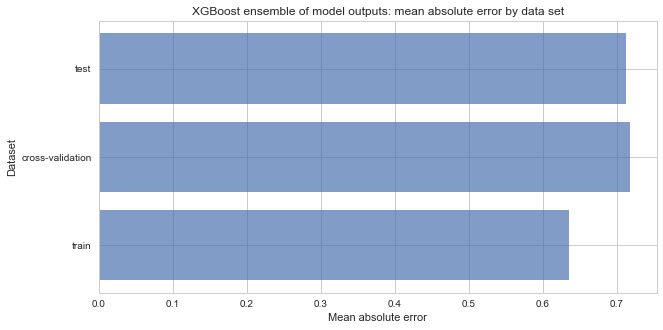

In [99]:
y_train_pred = np.clip(train_results_df['prediction'], a_min=1, a_max=5)
y_cv_pred = np.clip(cv_results_df['prediction'], a_min=1, a_max=5)
y_test_pred = np.clip(test_results_df['prediction'], a_min=1, a_max=5)

mae_train = np.abs(train_results_df['rating'] - y_train_pred).mean()
mae_cv = np.abs(cv_results_df['rating'] - y_cv_pred).mean()
mae_test = np.abs(test_results_df['rating'] - y_test_pred).mean()

print('mean absolute error, training set:', mae_train)
print('mean absolute error, cross-validation set:', mae_cv)
print('mean absolute error, test set:', mae_test)

mae_list = [mae_train, mae_cv, mae_test]

plt.figure(figsize = (10, 5))
ax = plt.barh([0,1,2], mae_list, alpha = 0.7)
plt.gca().set(yticks = [0,1,2], yticklabels = ['train', 'cross-validation', 'test'])
plt.gca().set(title = 'XGBoost ensemble of model outputs: mean absolute error by data set',
              ylabel = 'Dataset', xlabel = 'Mean absolute error')

mean absolute error, training set: 0.872138367905
mean absolute error, cross-validation set: 0.816143180837
mean absolute error, test set: 0.821584824044


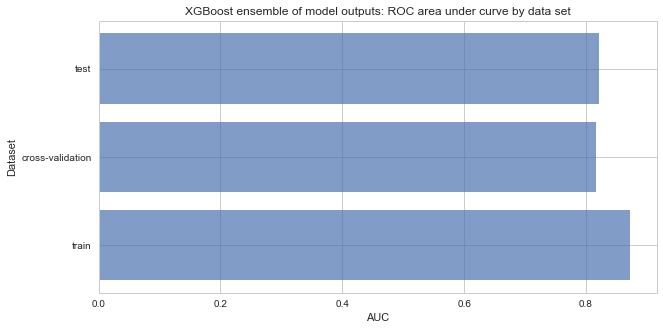

In [100]:
def calc_auc(data):
    y = data['rating'] >= 4
    y_pred = np.clip(data['prediction'], a_min=1, a_max=5)
    y_pred = y_pred / y_pred.max()
    auc = roc_auc_score(y, y_pred)
    return auc

auc_train = calc_auc(train_results_df)
auc_cv = calc_auc(cv_results_df)
auc_test = calc_auc(test_results_df)

print('ROC AUC, training set:', auc_train)
print('ROC AUC, cross-validation set:', auc_cv)
print('ROC AUC, test set:', auc_test)

auc_list = [auc_train, auc_cv, auc_test]

plt.figure(figsize = (10, 5))
ax = plt.barh([0,1,2], auc_list, alpha = 0.7)
plt.gca().set(yticks = [0,1,2], yticklabels = ['train', 'cross-validation', 'test'])
plt.gca().set(title = 'XGBoost ensemble of model outputs: ROC area under curve by data set',
              ylabel = 'Dataset', xlabel = 'AUC')